# Data Exploration and Temporal Analysis

## Libraries and Configurations

Import configuration files

In [106]:
from configparser import ConfigParser
import os

config = ConfigParser()
config.read("../config.ini")

['../config.ini']

Import **data libraries**

In [107]:
import pandas as pd

Import **other libraries**

In [108]:
from rich import traceback

traceback.install()

<bound method InteractiveShell.excepthook of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x112dcc610>>

Custom helper scripts

In [109]:
%cd ..
from scripts import plotHelper, timeHelper
%cd data_exploration_cleaning

/Users/bacci/Library/CloudStorage/SynologyDrive-giovanni/Research 🌱/Repositories/COMPACT/notebooks
/Users/bacci/Library/CloudStorage/SynologyDrive-giovanni/Research 🌱/Repositories/COMPACT/notebooks/data_exploration_cleaning


/Users/bacci/Library/CloudStorage/SynologyDrive-giovanni/Research 🌱/Repositories/COMPACT/.venv/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Import Data

In [110]:
# Combined dataframe raw
combined_df_csv = config["DEFAULT"]["interim_path"] + "combined_df.csv"

In [111]:
combined_df = pd.read_csv(combined_df_csv)

/var/folders/kz/mqbx964j4w53vxgzd7rlzx380000gn/T/ipykernel_24227/3840082691.py:1: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.read_csv(combined_df_csv)


Fixing columns data types

In [112]:
combined_df.dtypes

Timestamp                    object
MAC Address                  object
Channel                       int64
DS Channel                  float64
HT Capabilities              object
Extended Capabilities        object
Vendor Specific Tags         object
SSID                         object
Supported Rates              object
Extended Supported Rates     object
VHT Capabilities             object
HE Capabilities              object
Length                        int64
Label                        object
dtype: object

In [113]:
# Converting Timestamp to datetime
combined_df["Timestamp"] = pd.to_datetime(combined_df["Timestamp"])

# Converting Label to string
combined_df["Label"] = combined_df["Label"].astype(str)

# Converting SSID to string
combined_df["SSID"] = combined_df["SSID"].astype(str)

# Converting MAC Address to string
combined_df["MAC Address"] = combined_df["MAC Address"].astype(str)

# Converting HT Capabilities to string
combined_df["HT Capabilities"] = combined_df["HT Capabilities"].astype(str)

# Converting Extended Capabilities to string
combined_df["Extended Capabilities"] = combined_df["Extended Capabilities"].astype(str)

# Converting Vendor Specific Tags to string
combined_df["Vendor Specific Tags"] = combined_df["Vendor Specific Tags"].astype(str)

# Converting Supported Rates to string
combined_df["Supported Rates"] = combined_df["Supported Rates"].astype(str)

# Converting Extended Supported Rates to string
combined_df["Extended Supported Rates"] = combined_df[
    "Extended Supported Rates"
].astype(str)

# Converting VHT Capabilities to string
combined_df["VHT Capabilities"] = combined_df["VHT Capabilities"].astype(str)

# Converting HE Capabilities to string
combined_df["HE Capabilities"] = combined_df["HE Capabilities"].astype(str)

## Dataset Balancing

Average number of rows per label

In [114]:
print("Average number of rows per Label:", combined_df.groupby("Label").size().mean())

Average number of rows per Label: 2324.3636363636365


**Undersampling devices which have too many Probe Request to the average number of rows per label**

In [115]:
# Undersampling devices which have too many Probe Request to the average number of rows per label
# This is done to avoid having an unbalanced dataset

# Get the average number of rows per label
average_rows_per_label = combined_df.groupby("Label").size().mean()

# Get the labels which have more rows than the average
labels_to_undersample = (
    combined_df.groupby("Label")
    .size()[combined_df.groupby("Label").size() > average_rows_per_label]
    .index
)

# Get the labels which have less rows than the average
labels_to_keep = (
    combined_df.groupby("Label")
    .size()[combined_df.groupby("Label").size() <= average_rows_per_label]
    .index
)

# Get the rows which have a label which has more rows than the average
rows_to_undersample = combined_df[combined_df["Label"].isin(labels_to_undersample)]

# Get the rows which have a label which has less rows than the average
rows_to_keep = combined_df[combined_df["Label"].isin(labels_to_keep)]

# Undersample the rows which have a label which has more rows than the average
rows_to_undersample = (
    rows_to_undersample.groupby("Label")
    .apply(lambda x: x.sample(n=round(average_rows_per_label), random_state=42))
    .reset_index(drop=True)
)

# Combine the undersampled rows with the rows which have a label which has less rows than the average
combined_df = pd.concat([rows_to_keep, rows_to_undersample])

/var/folders/kz/mqbx964j4w53vxgzd7rlzx380000gn/T/ipykernel_24227/342106335.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=round(average_rows_per_label), random_state=42))


## Data Cleaning

Dropping columns not used for the temporal analysis

In [116]:
combined_df.drop(
    columns=[
        "HT Capabilities",
        "Extended Capabilities",
        "Vendor Specific Tags",
        "SSID",
        "Supported Rates",
        "Extended Supported Rates",
        "VHT Capabilities",
        "HE Capabilities",
    ],
    inplace=True,
)

In [117]:
combined_df

,Timestamp,MAC Address,Channel,DS Channel,Length,Label
0,2023-05-20 13:52:01.864465952,d2:6b:aa:b5:fb:ed,1,1.0,135,iPhone12Pro_C
1,2023-05-20 13:52:01.884716034,d2:6b:aa:b5:fb:ed,1,1.0,135,iPhone12Pro_C
2,2023-05-20 13:52:01.910542011,d2:6b:aa:b5:fb:ed,6,6.0,135,iPhone12Pro_C
3,2023-05-20 13:52:01.930788994,d2:6b:aa:b5:fb:ed,6,6.0,135,iPhone12Pro_C
4,2023-05-20 13:52:01.968745947,d2:6b:aa:b5:fb:ed,11,11.0,135,iPhone12Pro_C
...,...,...,...,...,...,...
13939,2021-07-07 12:02:57.579541922,da:a1:19:00:17:f9,6,1.0,182,XiaomiRedmiNote7_S
13940,2021-07-07 11:32:04.533828019,da:a1:19:1a:cc:8f,6,8.0,198,XiaomiRedmiNote7_S
13941,2021-07-07 11:46:50.089955091,da:a1:19:41:c9:b1,11,5.0,143,XiaomiRedmiNote7_S
13942,2021-07-07 12:16:31.309731960,da:a1:19:c7:24:b1,1,3.0,182,XiaomiRedmiNote7_S


In [118]:
# Sort the dataframe by MAC Address and Timestamp
combined_df.sort_values(by=["MAC Address", "Timestamp"], inplace=True)

# Group the dataframe by MAC Address
grouped_df = combined_df.groupby("MAC Address")

# Calculate the average interval between Probe Requests: time difference divided by number of packets in the group
combined_df["IFAT"] = (
    grouped_df["Timestamp"].diff() / grouped_df["Timestamp"].diff().count()
)

# Convert IFAT to seconds
combined_df["IFAT"] = combined_df["IFAT"].dt.total_seconds()

# Display the dataframe with the IFAT values
combined_df.fillna(0, inplace=True)

In [119]:
combined_df

,Timestamp,MAC Address,Channel,DS Channel,Length,Label,IFAT
32652,2021-07-08 08:54:07.078243017,00:0f:00:6a:68:8b,1,-1.0,76,SamsungJ6_K,0.000000e+00
32653,2021-07-08 08:54:08.105015993,00:0f:00:6a:68:8b,1,-1.0,289,SamsungJ6_K,3.246000e-05
32654,2021-07-08 08:54:08.107963085,00:0f:00:6a:68:8b,1,-1.0,289,SamsungJ6_K,9.300000e-08
32655,2021-07-08 08:54:08.141887903,00:0f:00:6a:68:8b,1,-1.0,289,SamsungJ6_K,1.072000e-06
32656,2021-07-08 08:54:08.174788952,00:0f:00:6a:68:8b,1,-1.0,289,SamsungJ6_K,1.040000e-06
...,...,...,...,...,...,...,...
6931,2023-10-12 13:44:31.617539644,fe:fc:07:34:10:69,1,1.0,132,iPhone11_C,7.300000e-07
46437,2021-06-30 17:15:54.225436926,fe:fc:aa:d1:89:d1,1,2.0,143,iPhone12_W,0.000000e+00
46438,2021-06-30 17:15:54.245695114,fe:fc:aa:d1:89:d1,1,2.0,143,iPhone12_W,6.400000e-07
5702,2023-10-12 21:49:14.122128725,fe:ff:ff:0f:64:5d,11,12.0,132,iPhone11_B,0.000000e+00


In [126]:
# remove rows with IFAT > 1000
combined_df = combined_df[combined_df["IFAT"] <= 0.000001]

/Users/bacci/Library/CloudStorage/SynologyDrive-giovanni/Research 🌱/Repositories/COMPACT/notebooks/scripts/plotHelper.py:163: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


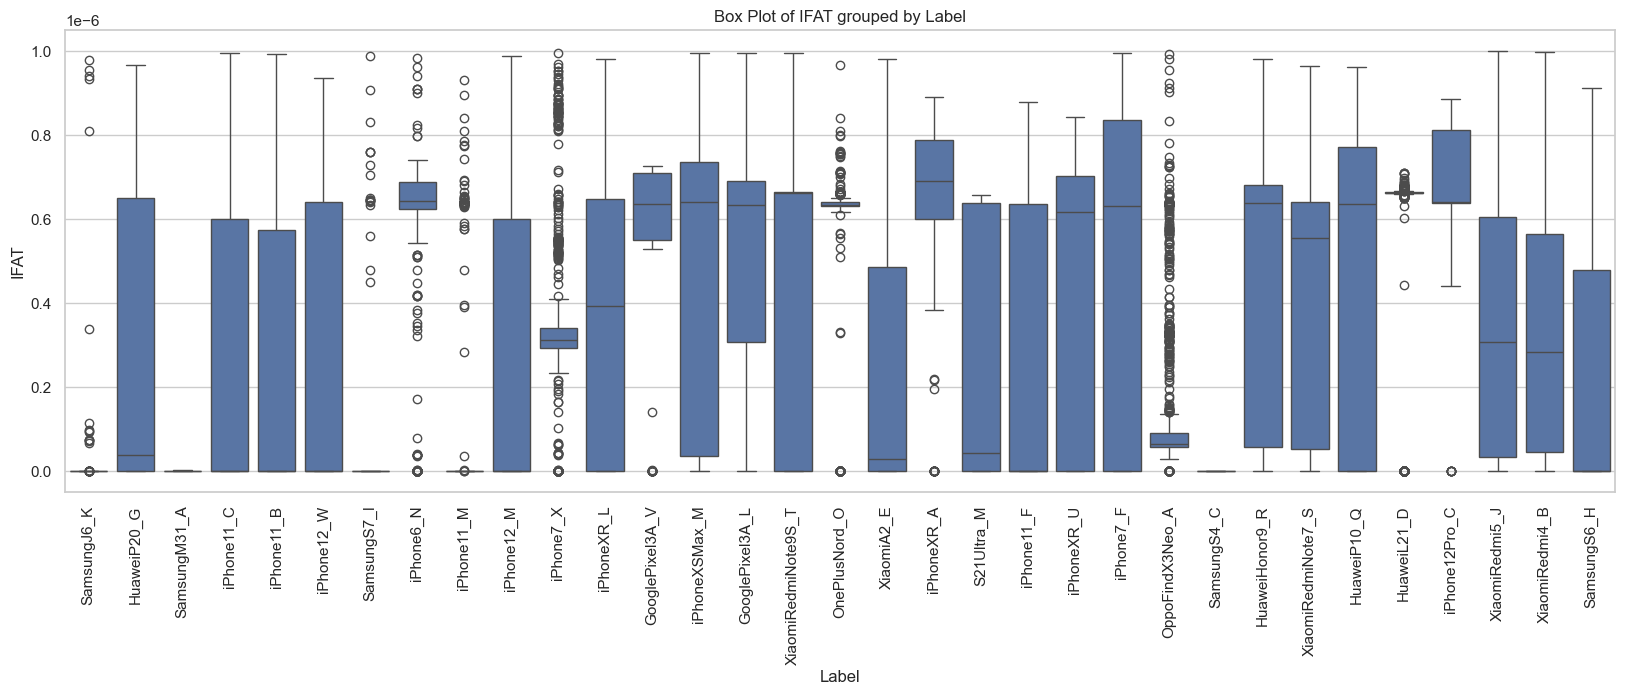

In [127]:
plotHelper.plot_boxplot(combined_df, "Label", "IFAT")